# Calculating Beat-Synchronous Chroma Features

Dan Ellis dpwe@ee.columbia.edu 2016-04-04

In [1]:
%pylab inline
from __future__ import print_function

import cPickle as pickle
import os
import time
import IPython

import numpy as np
import scipy
import sklearn.mixture

import librosa
import mir_eval

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [6]:
# Load in a single track from the 32kbps 16 kHz SR mono collection.
DATA_DIR = '/Users/dpwe/Downloads/prac10/data'

file_id = 'beatles/Let_It_Be/06-Let_It_Be'
y, sr = librosa.load(os.path.join(DATA_DIR, 'mp3s-32k', file_id + '.mp3'), sr=None)
print("sr=", sr, "duration=", y.shape[0]/float(sr))

sr= 16000 duration= 243.432


tempo (BPM)= 144.230769231 beat.shape= (550,)
[ 0.272  0.688  1.112  1.536  1.968]


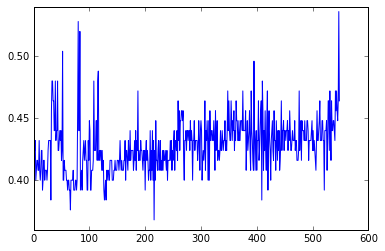

In [7]:
# Beat tracking.
hop_length = 128  # 8 ms at 16 kHz
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length, start_bpm=240)
print("tempo (BPM)=", tempo, "beat.shape=", beats.shape)
beat_times = beats * hop_length / float(sr)
print(beat_times[:5])
# Difference of successive beat times shows varying beat duration.
plot(np.diff(beat_times))

In [8]:
def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', origin='bottom', cmap='gray_r', **kwargs)

frame_chroma.shape: (12, 30430)
beat_chroma.shape: (551, 12)


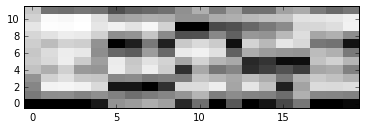

In [9]:
# CQT-based chromagram and beat-level aggregation.
frame_chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
print("frame_chroma.shape:", frame_chroma.shape)
beat_chroma = librosa.feature.sync(frame_chroma, beats).transpose()
print("beat_chroma.shape:", beat_chroma.shape)
plt.subplot(211)
my_imshow(beat_chroma[:20].transpose())

In [10]:
# Code to convert the Isophonics label files into beat-references we need.
def read_iso_label_file(filename):
    """Read in an isophonics-format chord label file."""
    times = []
    labels = []
    with open(filename, 'r') as f:
        for line in f:
            fields = line.strip().split(' ')
            start_secs = float(fields[0])
            end_secs = float(fields[1])
            times.append((start_secs, end_secs))
            labels.append(fields[2])
    return np.array(times), labels

def calculate_overlap_durations(ranges_a, ranges_b):
    """Calculate the duration of overlaps between all pairs of (start, end) intervals."""
    max_starts_matrix = np.maximum.outer(ranges_a[:, 0], ranges_b[:, 0])
    min_ends_matrix = np.minimum.outer(ranges_a[:, 1], ranges_b[:, 1])
    overlap_durations = np.maximum(0, min_ends_matrix - max_starts_matrix)
    return overlap_durations

def sample_label_sequence(sample_ranges, label_ranges, labels):
    """Find the most-overlapping label for a list of (start, end) intervals."""
    overlaps = calculate_overlap_durations(sample_ranges, label_ranges)
    best_label = np.argmax(overlaps, axis=1)
    return [labels[i] for i in best_label]

def chord_name_to_index(labels):
    """Convert chord name strings into model indices (0..25)."""
    indices = np.zeros(len(labels), dtype=int)
    root_degrees = {'C': 0, 'D': 2, 'E': 4, 'F':5, 'G': 7, 'A':9, 'B': 11}
    for label_index, label in enumerate(labels):
        if label == 'N' or label == 'X':
            # Leave at zero.
            continue
        root_degree = root_degrees[label[0].upper()]
        minor = False
        if len(label) > 1:
            if label[1] == '#':
                root_degree = (root_degree + 1) % 12
            if label[1] == 'b':
                root_degree = (root_degree - 1) % 12
            if ':' in label:
                modifier = label[label.index(':') + 1:]
                if modifier[:3] == 'min':
                    minor = True
        indices[label_index] = 1 + root_degree + 12 * minor
    return indices

beat_ranges = np.hstack([beat_times[:, np.newaxis], 
                         np.hstack([beat_times[1:], 
                                    2 * beat_times[-1] - beat_times[-2]])[:, np.newaxis]])
label_ranges, labels = read_iso_label_file(os.path.join(DATA_DIR, 'isolabels', file_id + '.txt'))
print(chord_name_to_index(sample_label_sequence(beat_ranges, label_ranges, labels)[:32]))

[ 1  1  1  1  8  8  8  8 22 22 22 22  6  6  6  6  1  1  1  1  8  8  8  8  6
  6  6  6  1  1  1  1]


(550, 12) (550,) (550,)


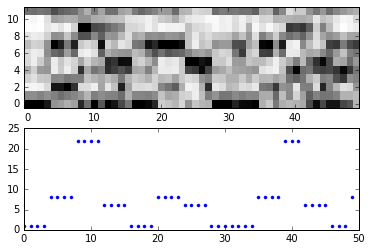

In [11]:
def calculate_chroma_and_labels_of_id(file_id):
    """Read the audio, calculate beat-sync chroma, sample the label file."""
    y, sr = librosa.load(os.path.join(DATA_DIR, 'mp3s-32k', file_id + '.mp3'), sr=None)
    hop_length = 128  # 8 ms at 16 kHz
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length, start_bpm=240)
    # Append a final beat time one beat beyond the end.
    extended_beat_frames = np.hstack([beat_frames, 2*beat_frames[-1] - beat_frames[-2]])
    frame_chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
    # Drop the first beat_chroma which is stuff before the first beat, 
    # and the final beat_chroma which is everything after the last beat time.
    beat_chroma = librosa.feature.sync(frame_chroma, extended_beat_frames).transpose()
    # Drop first row if the beat_frames start after the beginning.
    if beat_frames[0] > 0:
        beat_chroma = beat_chroma[1:]
    # Keep only as many frames as beat times.
    beat_chroma = beat_chroma[:len(beat_frames)]
    assert beat_chroma.shape[0] == beat_frames.shape[0]
    # MP3s encoded with lame have a 68 ms delay
    LAME_DELAY_SECONDS = 0.068
    frame_rate = sr / float(hop_length)
    extended_beat_times = extended_beat_frames / frame_rate - LAME_DELAY_SECONDS
    beat_times = extended_beat_times[:-1]
    beat_ranges = np.hstack([extended_beat_times[:-1, np.newaxis], 
                             extended_beat_times[1:, np.newaxis]])
    label_time_ranges, labels = read_iso_label_file(os.path.join(
        DATA_DIR, 'isolabels', file_id + '.txt'))
    beat_labels = sample_label_sequence(beat_ranges, label_time_ranges, labels)
    label_indices = chord_name_to_index(beat_labels)
    return beat_times, beat_chroma, label_indices

beat_times, beat_chroma, label_indices = calculate_chroma_and_labels_of_id(file_id)
print(beat_chroma.shape, beat_times.shape, label_indices.shape)
plt.subplot(211)
my_imshow(beat_chroma[:50].transpose())
plt.subplot(212)
plt.plot(label_indices[:50], '.')

In [13]:
# Read and write per-track data files in native Python serialized format.
def write_beat_chroma_labels(filename, beat_times, chroma_features, label_indices):
    """Write out the computed beat-synchronous chroma data."""
    # Create the enclosing directory if needed.
    directory = os.path.dirname(filename)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
    with open(filename, "w") as f:
        pickle.dump((beat_times, chroma_features, label_indices), f, pickle.HIGHEST_PROTOCOL)

def read_beat_chroma_labels(filename):
    """Read back a precomputed beat-synchronous chroma record."""
    with open(filename, "r") as f:
        beat_times, chroma_features, label_indices = pickle.load(f)
    return beat_times, chroma_features, label_indices

beatchromlab_filename = os.path.join(DATA_DIR, 'beatchromlabs', file_id + '.pkl')
write_beat_chroma_labels(beatchromlab_filename, beat_chroma, beat_times, label_indices)

cc, tt, ll = read_beat_chroma_labels(beatchromlab_filename)
print(cc.shape, tt.shape, ll.shape)

(550, 12) (550,) (550,)


In [14]:
# Read in the list of training file IDs.
def read_file_list(filename):
    """Read a text file with one item per line."""
    items = []
    with open(filename, 'r') as f:
        for line in f:
            items.append(line.strip())
    return items

train_list_filename = os.path.join(DATA_DIR, 'trainfilelist.txt')
train_files = read_file_list(train_list_filename)
test_list_filename = os.path.join(DATA_DIR, 'testfilelist.txt')
test_files = read_file_list(test_list_filename)

all_ids = train_files
all_ids.extend(test_files)
print("# ids:", len(all_ids))

# ids: 180


In [15]:
for number, file_id in enumerate(all_ids):
    print(time.ctime(), "File {:d} of {:d}: {:s}".format(number, len(all_ids), file_id))
    beat_times, beat_chroma, label_indices = calculate_chroma_and_labels_of_id(file_id)
    beatchromlab_filename = os.path.join(DATA_DIR, 'beatchromlabs', file_id + '.pkl')
    write_beat_chroma_labels(beatchromlab_filename, beat_times, beat_chroma, label_indices)

Tue Apr  5 22:56:00 2016 File 0 of 180: beatles/With_The_Beatles/01-It_Won_t_Be_Long
Tue Apr  5 22:56:19 2016 File 1 of 180: beatles/With_The_Beatles/02-All_I_ve_Got_To_Do
Tue Apr  5 22:56:34 2016 File 2 of 180: beatles/With_The_Beatles/03-All_My_Loving
Tue Apr  5 22:56:43 2016 File 3 of 180: beatles/With_The_Beatles/04-Don_t_Bother_Me
Tue Apr  5 22:57:05 2016 File 4 of 180: beatles/With_The_Beatles/05-Little_Child
Tue Apr  5 22:57:11 2016 File 5 of 180: beatles/With_The_Beatles/06-Till_There_Was_You
Tue Apr  5 22:57:23 2016 File 6 of 180: beatles/With_The_Beatles/07-Please_Mister_Postman
Tue Apr  5 22:57:47 2016 File 7 of 180: beatles/With_The_Beatles/08-Roll_Over_Beethoven
Tue Apr  5 22:57:55 2016 File 8 of 180: beatles/With_The_Beatles/09-Hold_Me_Tight
Tue Apr  5 22:58:01 2016 File 9 of 180: beatles/With_The_Beatles/10-You_Really_Got_A_Hold_On_Me
Tue Apr  5 22:58:09 2016 File 10 of 180: beatles/With_The_Beatles/11-I_Wanna_Be_Your_Man
Tue Apr  5 22:58:17 2016 File 11 of 180: beatles/